01 — Cohort Construction (Psychiatric Admissions)
Purpose of This Notebook

This notebook defines the psychiatric cohort used throughout the project.

The goal here is not analysis, modeling, or feature engineering.

It is to establish a reproducible and clinically defensible definition of psychiatric admissions using structured ICD diagnosis codes.

This is a methodological boundary-setting step.

All downstream analyses depend on the clarity of this definition.

Conceptual Rationale

Psychiatric admissions are not defined by admission type alone.They are identified through diagnostic coding patterns.

Therefore, this notebook:
    Uses ICD-9 and ICD-10 diagnosis codes
    Identifies psychiatric-related codes
    Maps them to hospital admissions
    Produces a filtered admission subset

The output is a structurally clean psychiatric admission table that becomes the anchor for all subsequent notebooks.

Rules for This Stage

To maintain methodological integrity:
    No feature engineering
    No temporal aggregation
    No cleaning beyond necessary filtering
    No outcome labeling
    No modeling

Only deterministic filtering based on diagnosis coding.

#Output of This Notebook

This notebook will generate:
    psy_admissions.csv
    Optional: psy_multi_dx_admissions.csv (≥2         psychiatric diagnoses)
    Filtered versions of strong-link tables (row-filter only)
These will be used in Notebook 02 for structural EDA.

In [3]:
import pandas as pd
from pathlib import Path

RAW = Path(r"D:\mimic-iv-3.1\Unzipped_raw_data")

In [4]:
# Explicit dtype locking for identifiers
admissions = pd.read_csv(
    RAW / "admissions.csv",
    dtype={"subject_id": "Int64", "hadm_id": "Int64"}
)

diagnoses = pd.read_csv(
    RAW / "diagnoses_icd.csv",
    dtype={"subject_id": "Int64", "hadm_id": "Int64", "icd_code": "string", "icd_version": "Int64"}
)

In [5]:
print("Admissions shape:", admissions.shape)
print("Diagnoses shape:", diagnoses.shape)

print("\nUnique admissions:", admissions["hadm_id"].nunique())
print("Unique diagnoses admissions:", diagnoses["hadm_id"].nunique())


Admissions shape: (546028, 16)
Diagnoses shape: (6364488, 5)

Unique admissions: 546028
Unique diagnoses admissions: 545497


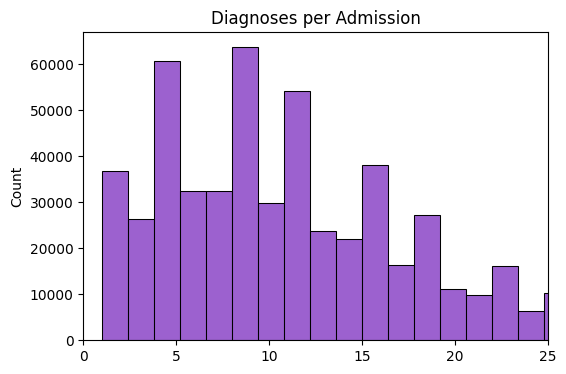

count    545497.000000
mean         11.667320
std           7.625992
min           1.000000
25%           6.000000
50%          10.000000
75%          16.000000
max          57.000000
dtype: float64

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

dx_counts = diagnoses.groupby("hadm_id").size()

plt.figure(figsize=(6,4))
sns.histplot(dx_counts, bins=40, color="#7B2CBF")
plt.xlim(0, 25)
plt.title("Diagnoses per Admission")
plt.show()

dx_counts.describe()

### Diagnostic Density Observations

- Nearly all admissions have at least one diagnosis (545,497).
- The median number of diagnoses per admission is 10.
- The upper quartile reaches 16 diagnoses.
- Extreme cases reach as high as 57 diagnoses.

This indicates substantial diagnostic multiplicity across admissions, with a pronounced right tail. 

Hospital encounters are rarely coded as single-condition events. Instead, they reflect layered clinical complexity. A subset of admissions exhibits very high diagnostic density, suggesting clustering of comorbid conditions rather than isolated pathology.

In [17]:
print("99th percentile:", dx_counts.quantile(0.99))

99th percentile: 36.0


### Upper Tail of Diagnostic Density

The 99th percentile of diagnoses per admission is 36, while the maximum is 57.

This indicates a thin but present extreme tail. Very high diagnostic counts are uncommon but not isolated anomalies.

The distribution suggests that while diagnostic multiplicity is common, extreme coding density is limited to a small subset of admissions.

In [7]:
high_complexity = (dx_counts >= 20).sum()

print("Admissions with ≥20 diagnoses:", high_complexity)
print("Percent of all admissions:",
      round(high_complexity / len(dx_counts) * 100, 2), "%")

Admissions with ≥20 diagnoses: 81456
Percent of all admissions: 14.93 %


### High Diagnostic Complexity Segment

- 81,456 admissions (≈14.9%) have 20 or more diagnoses.

This is not a marginal anomaly. Nearly one in seven admissions exhibits very high diagnostic density.

The distribution suggests that clinical encounters frequently involve multi-condition complexity rather than isolated diagnoses. The right tail is structurally meaningful, not accidental.



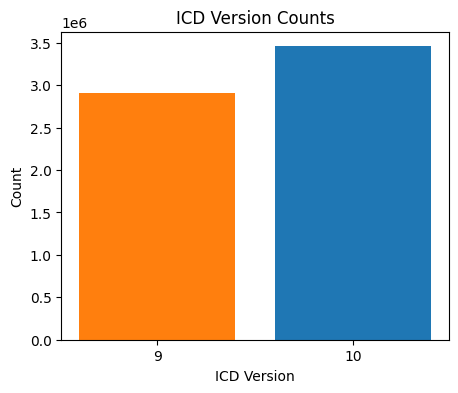

icd_version
9     2908741
10    3455747
Name: count, dtype: Int64

In [13]:
version_counts = diagnoses["icd_version"].value_counts().sort_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.bar(
    version_counts.index.astype(str),
    version_counts.values,
    color=["#ff7f0e", "#1f77b4"]  # ICD-9 (orange), ICD-10 (blue)
)

plt.title("ICD Version Counts")
plt.xlabel("ICD Version")
plt.ylabel("Count")
plt.show()

version_counts

### ICD Coding Regime Structure

- ICD-10 diagnoses: 3,455,747  
- ICD-9 diagnoses: 2,908,741  

Both coding systems are heavily represented.

This indicates a mixed temporal regime within the dataset, reflecting the historical transition from ICD-9 to ICD-10 rather than a single uniform coding era.

Any downstream analysis must acknowledge that diagnostic representation may differ across coding systems due to structural differences in code granularity.

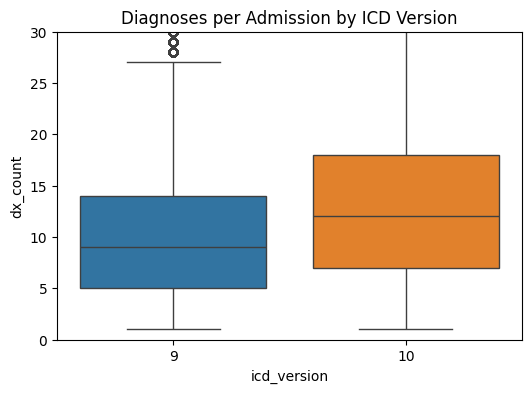

,count,mean,std,min,25%,50%,75%,max
icd_version,,,,,,,,
9,291130.0,9.991210,6.761152,1.0,5.0,9.0,14.0,39.0
10,254377.0,13.585139,8.092419,1.0,7.0,12.0,18.0,39.0


In [11]:
# Count diagnoses per admission per ICD version
dx_version_counts = (
    diagnoses
    .groupby(["hadm_id", "icd_version"])
    .size()
    .reset_index(name="dx_count")
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

sns.boxplot(
    data=dx_version_counts,
    x="icd_version",
    y="dx_count",
    hue="icd_version",
    palette=["#1f77b4", "#ff7f0e"],
    legend=False
)

plt.ylim(0, 30)
plt.title("Diagnoses per Admission by ICD Version")
plt.show()

dx_version_counts.groupby("icd_version")["dx_count"].describe()


### Diagnostic Density by Coding Regime

ICD-10 admissions exhibit consistently higher diagnostic density than ICD-9 admissions.

- Median diagnoses per admission:
  - ICD-9: 9
  - ICD-10: 12

- Mean diagnoses per admission:
  - ICD-9: ~10
  - ICD-10: ~13.6

This suggests that ICD-10 admissions are coded more densely. The observed increase in diagnostic multiplicity may therefore reflect both clinical complexity and structural differences in coding granularity between regimes.

Diagnostic density should not be interpreted purely as clinical instability without acknowledging this systemic shift.


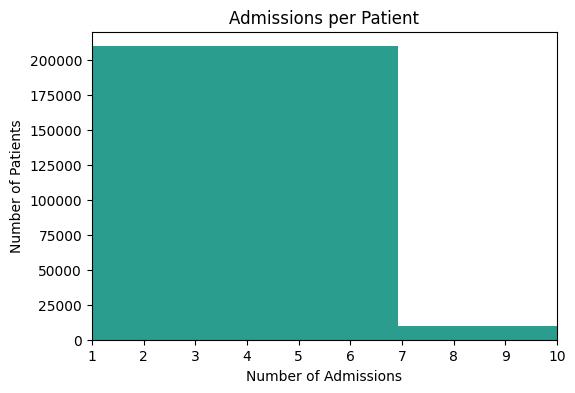

count    223452.000000
mean          2.443603
std           3.574410
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max         238.000000
dtype: float64

In [14]:
adm_per_patient = admissions.groupby("subject_id").size()

plt.figure(figsize=(6,4))
plt.hist(adm_per_patient, bins=40, color="#2a9d8f")
plt.xlim(1, 10)
plt.title("Admissions per Patient")
plt.xlabel("Number of Admissions")
plt.ylabel("Number of Patients")
plt.show()

adm_per_patient.describe()

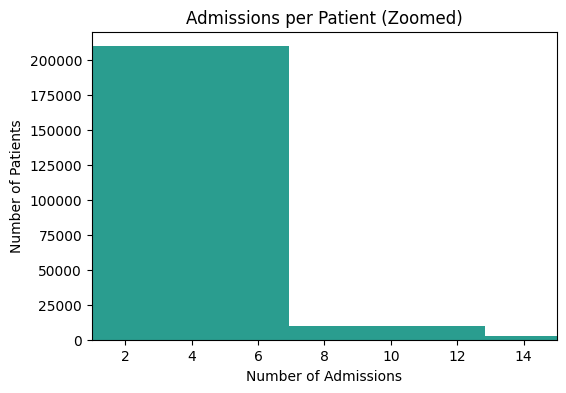

In [15]:
plt.figure(figsize=(6,4))
plt.hist(adm_per_patient, bins=40, color="#2a9d8f")
plt.xlim(1, 15)   # zoom into realistic range
plt.title("Admissions per Patient (Zoomed)")
plt.xlabel("Number of Admissions")
plt.ylabel("Number of Patients")
plt.show()

In [16]:
print("Max admissions for a single patient:", adm_per_patient.max())

print("\nTop 10 highest admission counts:")
print(adm_per_patient.sort_values(ascending=False).head(10))


Max admissions for a single patient: 238

Top 10 highest admission counts:
subject_id
15496609    238
15464144    185
10714009    163
16662316    142
14394983    138
15229574    130
11582633    105
17011846    104
13475033    103
18284271    101
dtype: int64


### Repeat Admission Structure

The maximum number of admissions for a single patient is 238.

The top 10 patients each have over 100 admissions.

This indicates the presence of extreme longitudinal churn within the hospital system. While most patients likely have few admissions, a small subset exhibits repeated and intensive interaction with hospital services.

The distribution is heavily right-skewed, suggesting that system-level instability may concentrate within specific high-utilization patients rather than being evenly distributed.

In [18]:
single_adm = (adm_per_patient == 1).sum()
repeat_adm = (adm_per_patient > 1).sum()

total_patients = len(adm_per_patient)

print("Single-admission patients:", single_adm)
print("Repeat-admission patients:", repeat_adm)
print("Percent repeat:",
      round(repeat_adm / total_patients * 100, 2), "%")

Single-admission patients: 123289
Repeat-admission patients: 100163
Percent repeat: 44.83 %


### Repeat Admission Prevalence

- Single-admission patients: 123,289  
- Repeat-admission patients: 100,163  
- Percentage with multiple admissions: 44.83%

Nearly half of patients experience more than one admission.

This suggests that recurrent hospital interaction is structurally common rather than limited to a small group of extreme high-utilization cases.

While a thin extreme tail exists (patients with >100 admissions), longitudinal churn is broadly distributed across the population.

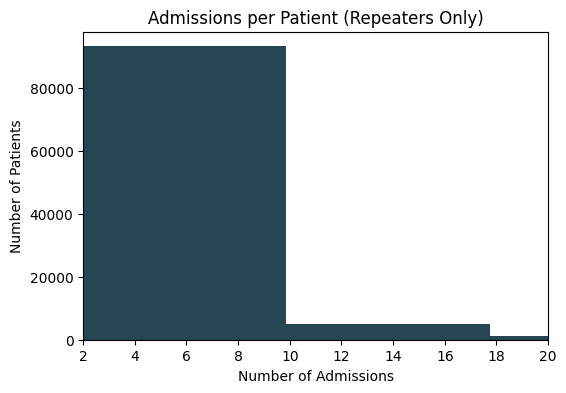

count    100163.000000
mean          4.220511
std           4.772863
min           2.000000
25%           2.000000
50%           3.000000
75%           4.000000
max         238.000000
dtype: float64

In [19]:
repeat_only = adm_per_patient[adm_per_patient > 1]

plt.figure(figsize=(6,4))
plt.hist(repeat_only, bins=30, color="#264653")
plt.xlim(2, 20)
plt.title("Admissions per Patient (Repeaters Only)")
plt.xlabel("Number of Admissions")
plt.ylabel("Number of Patients")
plt.show()

repeat_only.describe()

### Repeat Admission Intensity

Among patients with multiple admissions:

- Median admissions: 3
- 75th percentile: 4
- Mean: ~4.2
- Maximum: 238

Most repeaters experience 2–4 admissions rather than extreme churn. While a thin tail of very high-utilization patients exists, the majority of recurrence is moderate rather than extreme.

This suggests that longitudinal instability is common but typically occurs at modest repetition levels, with a small subset driving extreme system churn.

In [20]:
# Create repeat flag at patient level
repeat_flag = (adm_per_patient > 1).rename("is_repeat")

# Map repeat flag to admissions
admissions_repeat = admissions.merge(
    repeat_flag,
    left_on="subject_id",
    right_index=True
)

# Attach diagnostic counts per admission
adm_dx = dx_counts.rename("dx_count").reset_index()

admissions_repeat = admissions_repeat.merge(
    adm_dx,
    on="hadm_id",
    how="left"
)

# Compare distributions
admissions_repeat.groupby("is_repeat")["dx_count"].describe()

,count,mean,std,min,25%,50%,75%,max
is_repeat,,,,,,,,
False,123138.0,9.586919,7.301997,1.0,4.0,8.0,13.0,39.0
True,422359.0,12.273857,7.611586,1.0,7.0,11.0,17.0,57.0


### Diagnostic Density and Repeat Admissions

Admissions belonging to repeat patients exhibit consistently higher diagnostic density.

- Median diagnoses (single-admission patients): 8
- Median diagnoses (repeat patients): 11

This indicates a structural association between recurrence and diagnostic complexity. Patients who re-enter the hospital system tend to have more layered diagnostic documentation per admission.

This establishes an important baseline: complexity and longitudinal churn are already linked at the general hospital level. Any psychiatric-specific instability must therefore be interpreted relative to this broader system behavior.

In [21]:
# ICD-10 psychiatric codes (start with 'F')
psych_icd10 = diagnoses[
    (diagnoses["icd_version"] == 10) &
    (diagnoses["icd_code"].str.startswith("F", na=False))
]

# ICD-9 psychiatric range (290–319)
psych_icd9 = diagnoses[
    (diagnoses["icd_version"] == 9) &
    (diagnoses["icd_code"].str[:3].astype(str).isin(
        [str(i) for i in range(290, 320)]
    ))
]

psych_diagnoses = pd.concat([psych_icd10, psych_icd9])

print("Psych diagnosis rows:", psych_diagnoses.shape[0])
print("Unique psychiatric admissions:", psych_diagnoses["hadm_id"].nunique())

Psych diagnosis rows: 423435
Unique psychiatric admissions: 238565


### Psychiatric Cohort Scale

Using ICD-10 codes starting with “F” and ICD-9 codes 290–319:

- Psychiatric diagnosis rows: 423,435  
- Unique psychiatric admissions: 238,565  

This represents approximately 43–44% of all admissions.

Psychiatric coding is therefore not marginal within the dataset but structurally prevalent. The cohort reflects a substantial portion of hospital encounters rather than a narrow specialty subset.

In [22]:
psy_hadm_ids = psych_diagnoses["hadm_id"].unique()

psy_admissions = admissions[
    admissions["hadm_id"].isin(psy_hadm_ids)
].copy()

print("Total admissions:", admissions.shape[0])
print("Psych admissions:", psy_admissions.shape[0])
print("Percent psychiatric:",
      round(psy_admissions.shape[0] / admissions.shape[0] * 100, 2), "%")

Total admissions: 546028
Psych admissions: 238565
Percent psychiatric: 43.69 %


### Final Psychiatric Cohort Size

- Total admissions: 546,028  
- Psychiatric admissions: 238,565  
- Percentage psychiatric: 43.69%

Nearly half of all admissions include at least one psychiatric ICD code under the defined criteria.

Psychiatric diagnoses are therefore not isolated events within the dataset but are structurally common across hospital encounters.

In [23]:
# Count psychiatric diagnoses per admission
psych_dx_per_adm = (
    psych_diagnoses.groupby("hadm_id")
    .size()
    .rename("psych_dx_count")
)

psy_admissions = psy_admissions.merge(
    psych_dx_per_adm,
    on="hadm_id",
    how="left"
)

psy_admissions["psych_dx_count"] = psy_admissions["psych_dx_count"].fillna(0)

psy_admissions["psych_multi_flag"] = psy_admissions["psych_dx_count"] > 1

psy_admissions["psych_dx_count"].describe()

count    238565.000000
mean          1.774925
std           1.144404
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          14.000000
Name: psych_dx_count, dtype: float64

### Psychiatric Diagnostic Layering

Within the psychiatric cohort:

- Median psychiatric diagnoses per admission: 1
- 75th percentile: 2
- Mean: ~1.77
- Maximum: 14

Most psychiatric admissions contain a single psychiatric ICD code, with layered psychiatric coding occurring in a smaller subset.

This suggests that psychiatric complexity often coexists with broader medical complexity rather than manifesting as multiple psychiatric diagnoses alone.

In [24]:
# Attach total diagnostic density
psy_admissions = psy_admissions.merge(
    dx_counts.rename("total_dx_count").reset_index(),
    on="hadm_id",
    how="left"
)

# Attach repeat flag (patient-level)
psy_admissions = psy_admissions.merge(
    repeat_flag.rename("is_repeat"),
    left_on="subject_id",
    right_index=True,
    how="left"
)

# Quick sanity check
psy_admissions[["psych_dx_count", "total_dx_count", "is_repeat"]].describe()

,psych_dx_count,total_dx_count
count,238565.000000,238565.000000
mean,1.774925,13.224970
std,1.144404,8.087163
min,1.000000,1.000000
25%,1.000000,7.000000
50%,1.000000,12.000000
75%,2.000000,18.000000
max,14.000000,42.000000


### Psychiatric vs Overall Diagnostic Density

Within the psychiatric cohort:

- Median psychiatric diagnoses: 1
- Median total diagnoses: 12

Psychiatric admissions typically include a single psychiatric ICD code embedded within broader medical complexity.

Total diagnostic density remains high (median = 12), indicating that psychiatric coding frequently coexists with layered medical comorbidity rather than representing isolated psychiatric-only encounters.

In [25]:
# Define threshold
high_complex_threshold = 18

psy_admissions["high_total_complexity"] = (
    psy_admissions["total_dx_count"] >= high_complex_threshold
)

# Quick check
psy_admissions["high_total_complexity"].value_counts()

high_total_complexity
False    175919
True      62646
Name: count, dtype: int64

### High-Complexity Psychiatric Subgroup

Using a threshold of total_dx_count ≥ 18 (75th percentile):

- High-complexity psychiatric admissions: 62,646
- Lower-complexity psychiatric admissions: 175,919

Approximately one quarter of psychiatric admissions fall into a high overall diagnostic complexity tier.

This subgroup represents layered multimorbidity embedded within psychiatric-coded encounters and may serve as a structurally meaningful instability tier for downstream modeling.

In [26]:
psy_admissions.to_csv("psy_admissions_structured.csv", index=False)

In [27]:
psy_admissions.dtypes

subject_id               Int64
hadm_id                  Int64
admittime                  str
dischtime                  str
deathtime                  str
admission_type             str
admit_provider_id          str
admission_location         str
discharge_location         str
insurance                  str
language                   str
marital_status             str
race                       str
edregtime                  str
edouttime                  str
hospital_expire_flag     int64
psych_dx_count           int64
psych_multi_flag          bool
total_dx_count           int64
is_repeat                 bool
high_total_complexity     bool
dtype: object